In [25]:
import glob
import pandas as pd
import cv2
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from shapely.wkt import loads
import shapely
from shapely.geometry import LineString, Polygon, Point
from skimage import measure
from shapely.ops import split
from shapely.ops import linemerge, unary_union, polygonize
import tqdm

In [ ]:
# geometry results
# files_A = glob.glob('data/geometry_results_dl_vb_midlines/*.csv')
files_B = glob.glob('data/geometry_results_midlines_juhani/*.csv')

# files = files_A + files_B

dfs = []
for file in files_B:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs, ignore_index=True)

df['level'] = df['level'].str.replace('_IVD', '')

# add _IMG0000 if slice number is less than 10 and _IMG000 if slice number is greater than 10
df['slice_number'] = df['slice_number'].astype(str)
df['slice_number'] = df['slice_number'].apply(lambda x: 'IMG0000' + x if len(x) == 1 else x)
df['slice_number'] = df['slice_number'].apply(lambda x: 'IMG000' + x if len(x) == 2 else x)

In [27]:
def getExtrapoledLine(p1,p2, amount):

    'Creates a line extrapoled in p1->p2 direction'
    EXTRAPOL_RATIO = amount
    a = p1
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )

    return shapely.geometry.LineString([a,b])


def cut_polygon_by_line(polygon, line):

    merged = linemerge([polygon.boundary, line])
    borders = unary_union(merged)
    polygons = polygonize(borders)

    return list(polygons)

def midpoint(x0, y0, x1, y1):
    x = ((x0+x1)/2, (y0+y1)/2)
    
    return shapely.Point(x)

0it [00:00, ?it/s]

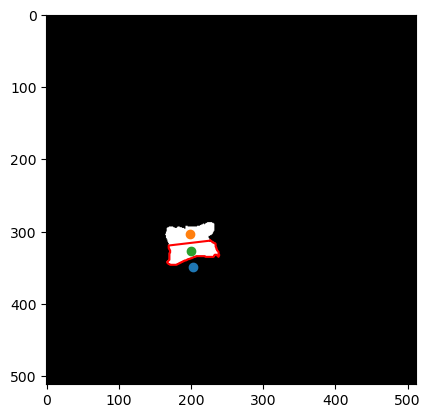

1it [00:00,  2.14it/s]

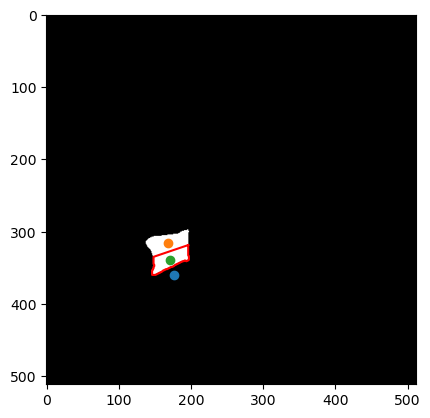

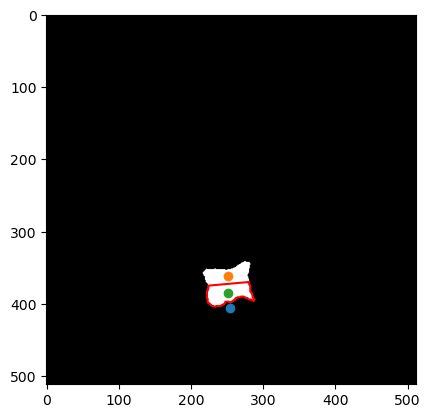

3it [00:00,  5.63it/s]

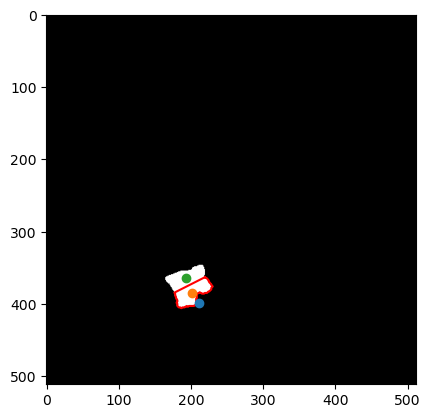

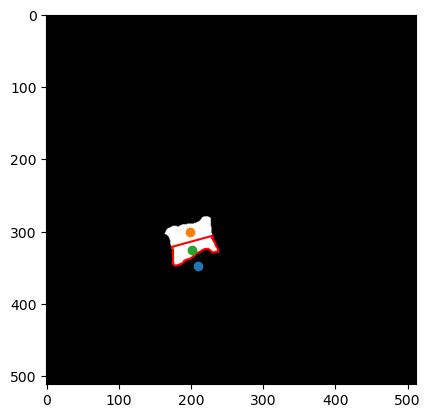

5it [00:00,  7.76it/s]

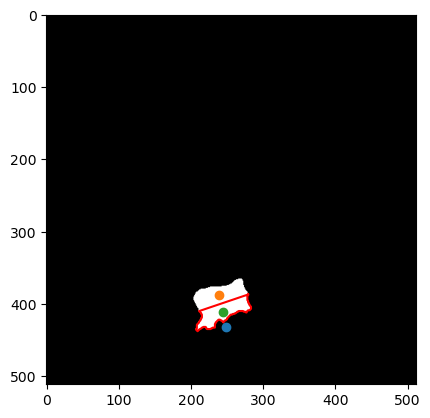

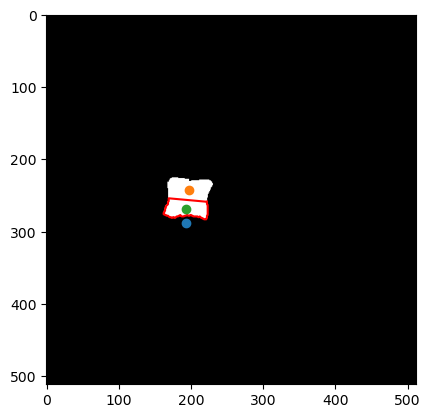

7it [00:01,  7.95it/s]

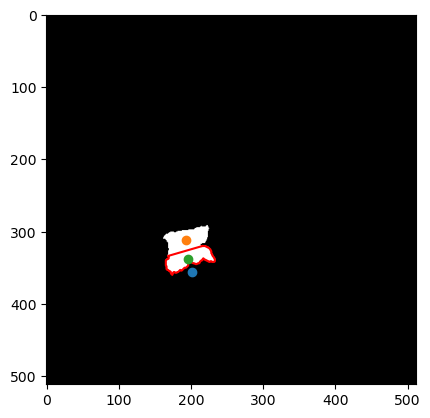

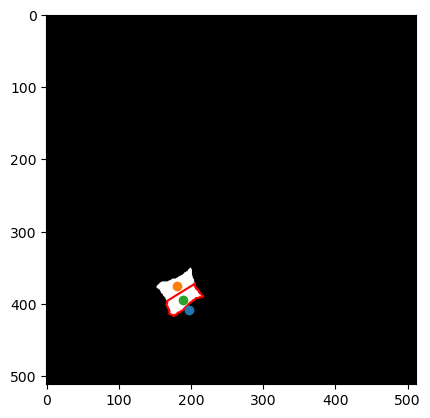

9it [00:01,  9.19it/s]

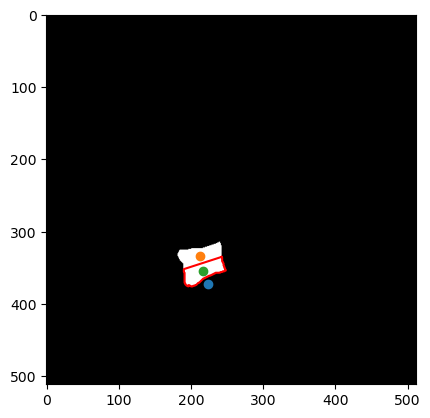

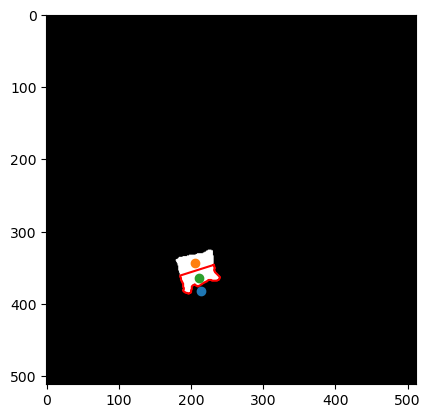

11it [00:01,  9.93it/s]

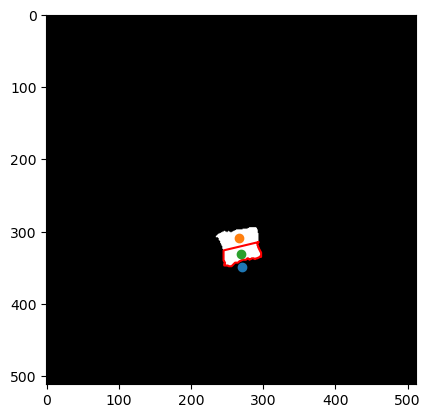

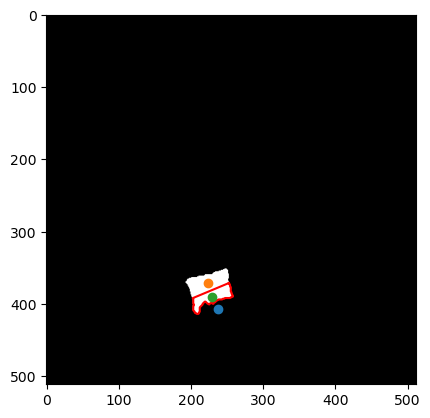

13it [00:01, 10.26it/s]

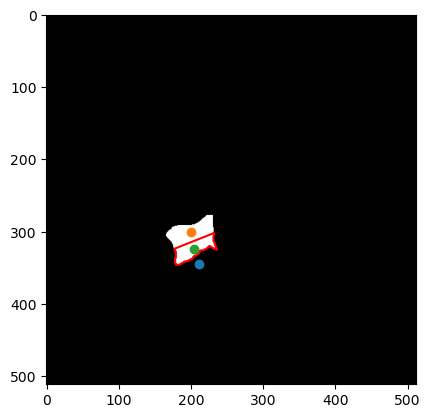

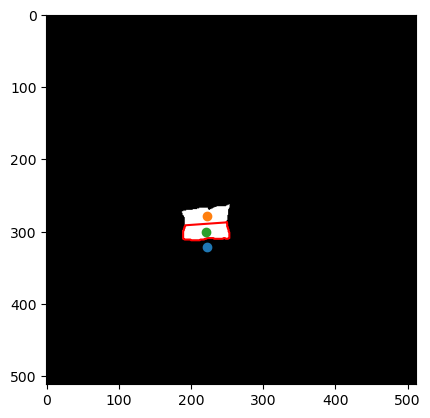

15it [00:01, 11.05it/s]

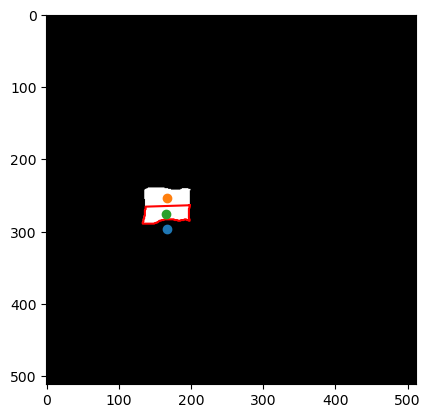

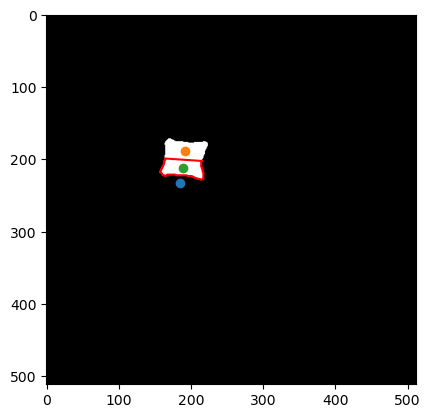

17it [00:01, 11.66it/s]

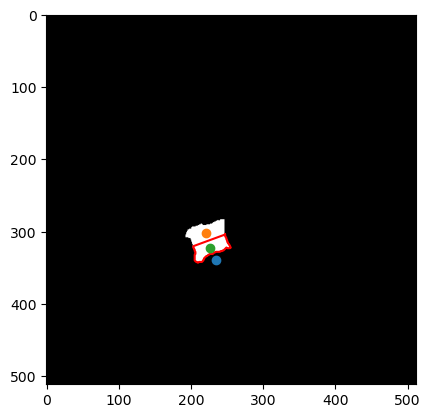

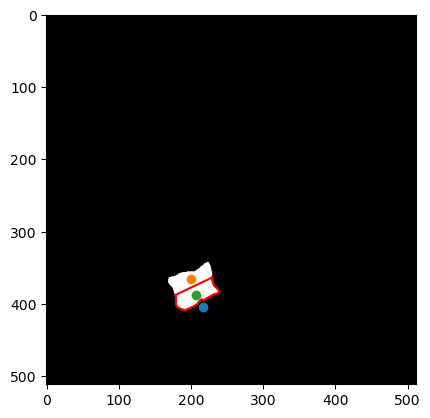

19it [00:02, 12.02it/s]

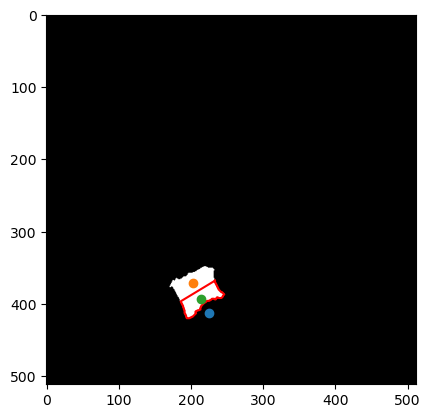

20it [00:02,  9.62it/s]
0it [00:00, ?it/s]

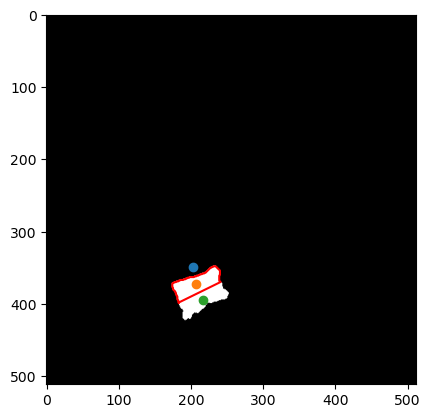

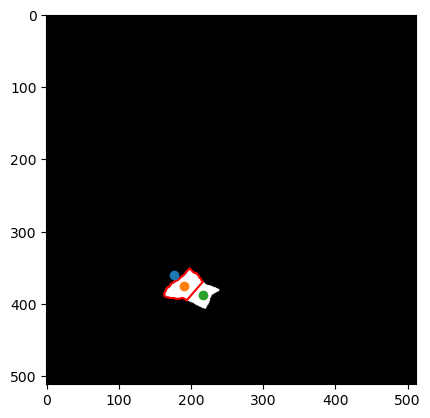

2it [00:00,  9.84it/s]

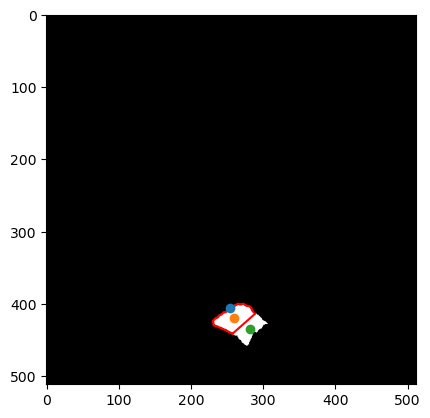

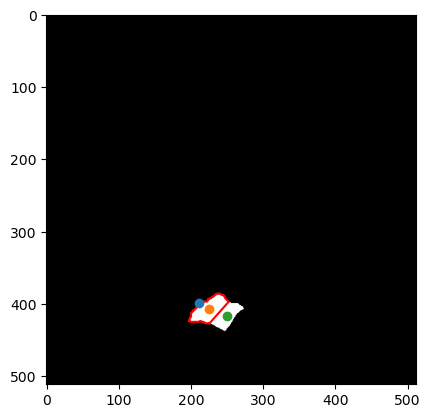

4it [00:00, 10.94it/s]

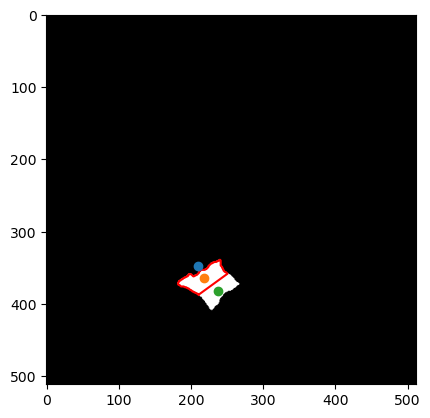

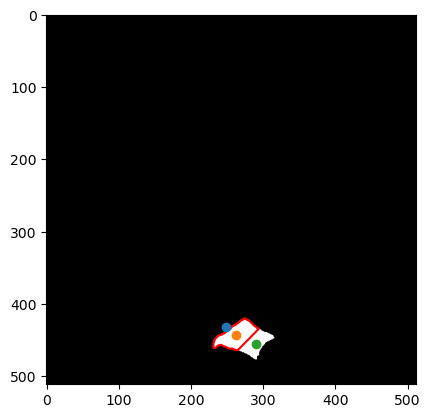

6it [00:00, 11.68it/s]

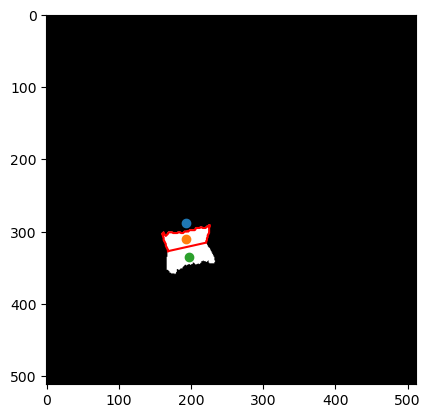

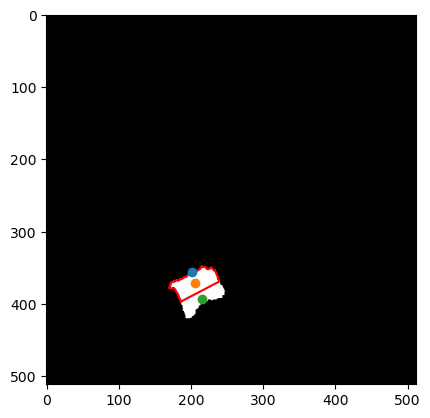

8it [00:00, 12.24it/s]

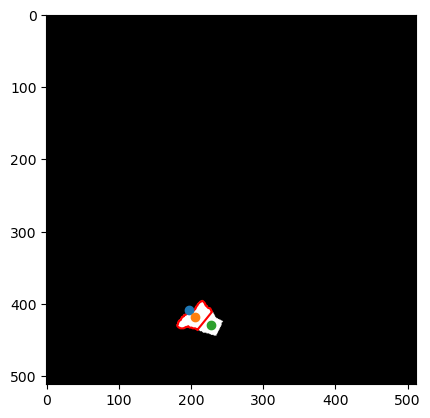

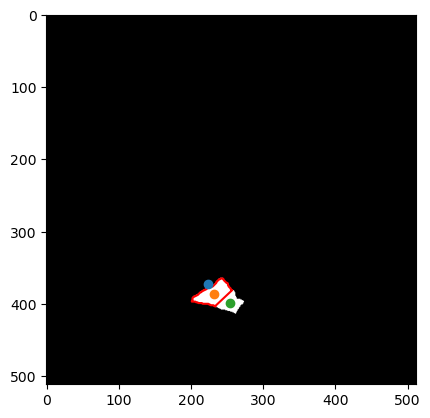

10it [00:00, 12.58it/s]

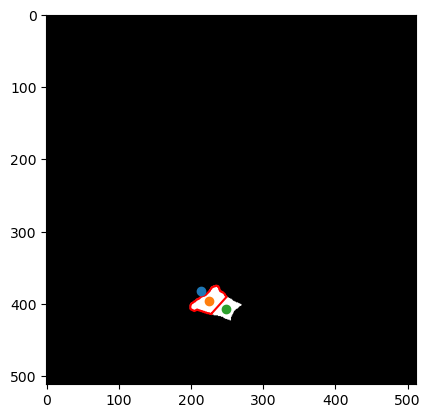

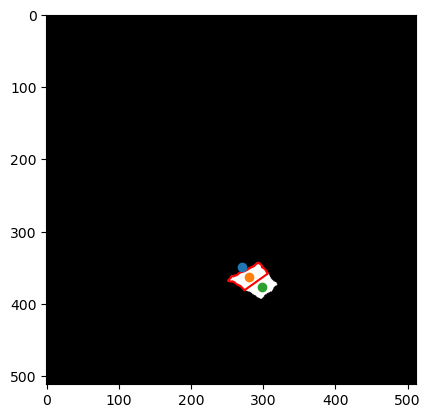

12it [00:00, 12.75it/s]

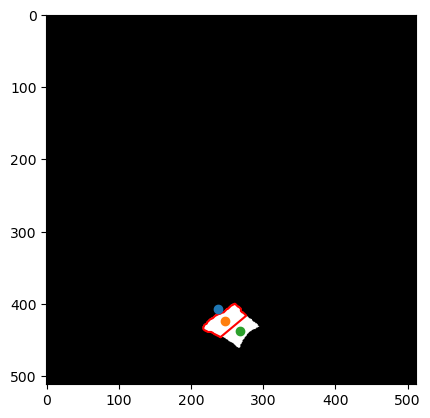

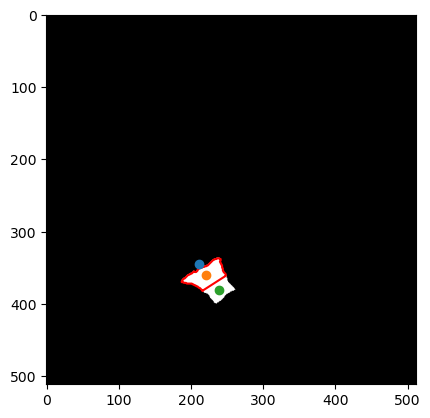

14it [00:01, 12.78it/s]

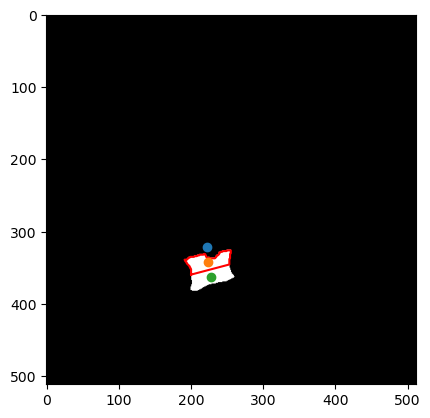

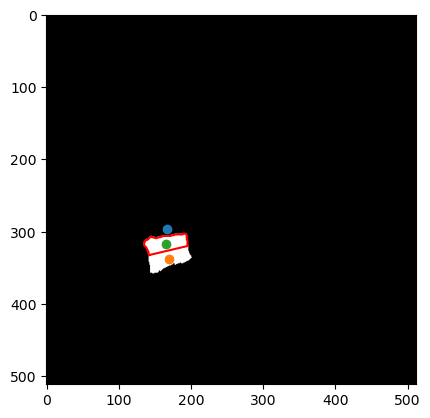

16it [00:01, 12.71it/s]

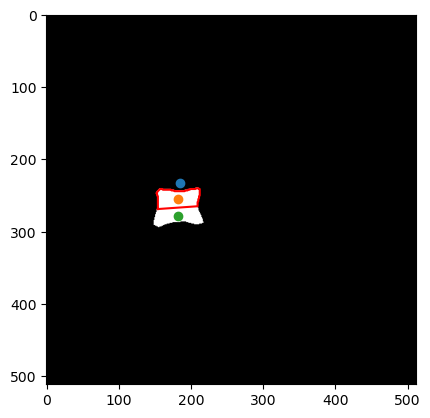

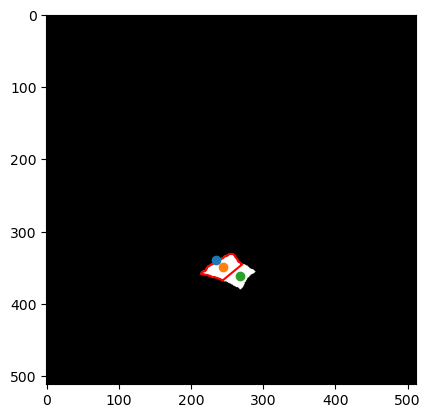

18it [00:01, 11.67it/s]

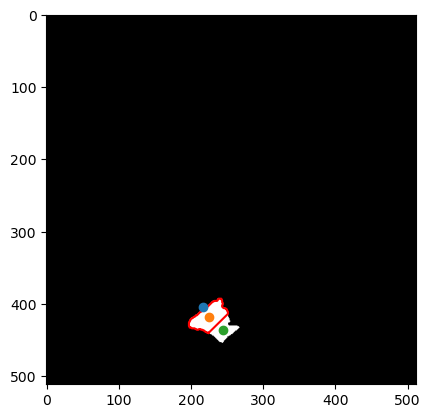

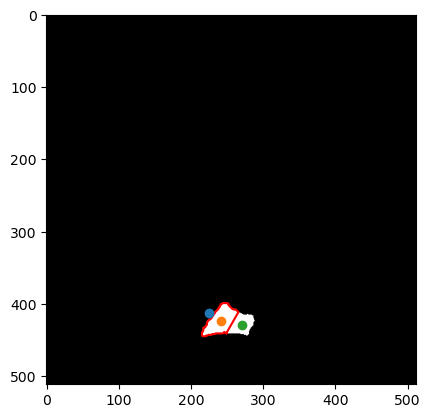

20it [00:01, 12.05it/s]


In [ ]:
nrrd_dir = '../radiospinomics/data/nrrd/all_masks/'

regions = ['cranial', 'caudal']

errors = []

# take a randomw 20 rows from the dataframe
df = df.sample(20)

for i, region in enumerate(regions):
    for index, row in tqdm.tqdm(df.iterrows()):
        mask_save_path = f'{nrrd_dir}juhani/{row["level"]}_{region}BEP-{row["project_ID"]}_{row["slice_number"]}.nrrd'

        # if os.path.exists(mask_save_path):
        #     continue

        vb = row['level'].split('_')[i] 
        nrrd_path = f'{nrrd_dir}juhani/{vb}_VB-{row["project_ID"]}_{row["slice_number"]}.nrrd'

        try: 
            mask = sitk.ReadImage(nrrd_path)
            array = sitk.GetArrayFromImage(mask)
            contours = cv2.findContours(array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 2:
                contour_areas = [Polygon(contour).area for contour in contours]
                max_contour = contours[np.argmax(contour_areas)]
                np.squeeze(max_contour)
                polygon = Polygon(max_contour)
            else:
                contours = np.squeeze(contours[0])
                polygon = Polygon(contours)
        except:
            errors.append(nrrd_path)
            continue
        
        vb_points = row[f'{region}_vb_diameter_points']
        vb_points = loads(vb_points)

        # get the two points in the line as numpy arrays
        points = list(vb_points.coords)

        # get the longer line to ensure it corsses the polygon
        longer_line = getExtrapoledLine(points[0], points[1], 1.7)
        points = list(longer_line.coords)
        longer_line = getExtrapoledLine(points[1], points[0], 1.7)
        points = list(longer_line.coords)

        split_vb = cut_polygon_by_line(polygon, longer_line)

        # find the midpoint between row['ivd_ant_point] and row['ivd_post_point']
        ivd_ant_point = loads(row['ivd_anterior_point'])
        ivd_post_point = loads(row['ivd_posterior_point'])
        x = midpoint(ivd_ant_point.x, ivd_ant_point.y, ivd_post_point.x, ivd_post_point.y)

        # find the center of the split_vb[0] and split_vb[1]
        split_vb_0 = split_vb[0]
        split_vb_1 = split_vb[1]

        split_vb_0_center = split_vb_0.centroid
        split_vb_1_center = split_vb_1.centroid

        # find which center is closer to the IVD midpoint
        split_vb_0_dist = split_vb_0_center.distance(x)
        split_vb_1_dist = split_vb_1_center.distance(x)

        # which is bigger
        if split_vb_0_dist > split_vb_1_dist:
            split_vb = split_vb_1
        else:
            split_vb = split_vb_0

        # save split_vb as a nrrd mask filled with 200 and 0
        # split_vb_mask = np.zeros(array.shape)
        # split_vb_mask = cv2.fillPoly(split_vb_mask, np.array([split_vb.exterior.coords], dtype=np.int32), 200)
        # split_vb_mask = sitk.GetImageFromArray(split_vb_mask)
        # split_vb_mask.CopyInformation(mask)
        # sitk.WriteImage(split_vb_mask, mask_save_path)

        # plot the split_vb in red a blue and the point x
        fig, ax = plt.subplots()
        # plot the array as gray image
        ax.imshow(array, cmap='gray')
        # ax.plot(*polygon.exterior.xy)
        ax.plot(*split_vb.exterior.xy, color='red')
        ax.plot(x.x, x.y, 'o')
        ax.plot(split_vb_0_center.x, split_vb_0_center.y, 'o')
        ax.plot(split_vb_1_center.x, split_vb_1_center.y, 'o')
        plt.show()